<a href="https://colab.research.google.com/github/sazio/NMAs/blob/main/Data_Loader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis of Stringer Dataset 
@authors: Simone Azeglio, Chetan Dhulipalla , Khalid Saifullah 


Part of the code here has been taken from [Neuromatch Academy's Computational Neuroscience Course](https://compneuro.neuromatch.io/projects/neurons/README.html), and specifically from [this notebook](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/neurons/load_stringer_spontaneous.ipynb)

# to do list

1. custom normalization: dividing by mean value per neuron
1a. downsampling: convolve then downsample by 5
2. training validation split: withhold last 20 percent of time series for testing
3. RNN for each layer: a way to capture the dynamics inside each layer instead of capturing extra dynamics from inter-layer interactions. it will be OK to compare the different RNNs. maintain same neuron count in each layer to reduce potential bias 
4. layer weight regularization: L2 
5. early stopping , dropout?

In [1]:
#%%capture
#!pip install wandb --upgrade --quiet

In [2]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sazio (use `wandb login --relogin` to force relogin)


True

## Loading of Stringer spontaneous data



In [3]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

In [4]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Exploratory Data Analysis (EDA)

In [5]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [6]:
# functions 

def moving_avg(array, factor = 5):
    """Reducing the number of compontents by averaging of N = factor
    subsequent elements of array"""
    zeros_ = np.zeros((array.shape[0], 2))
    array = np.hstack((array, zeros_))

    array = np.reshape(array, (array.shape[0],  int(array.shape[1]/factor), factor))
    array = np.mean(array, axis = 2)

    return array

## Extracting Data for RNN (or LFADS)
The first problem to address is that for each layer we don't have the exact same number of neurons. We'd like to have a single RNN encoding all the different layers activities, to make it easier we can take the number of neurons ($N_{neurons} = 1131$ of the least represented class (layer) and level out each remaining class. 

In [7]:
# Extract labels from z - coordinate
from sklearn import preprocessing
x, y, z = dat['xyz']

le = preprocessing.LabelEncoder()
labels = le.fit_transform(z)
### least represented class (layer with less neurons)
n_samples = np.histogram(labels, bins=9)[0][-1]

In [8]:
### Data for LFADS / RNN 
import pandas as pd 
dataSet = pd.DataFrame(dat["sresp"])
dataSet["label"] = labels 

In [9]:
# it can be done in one loop ... 
data_ = []
for i in range(0, 9):
    data_.append(dataSet[dataSet["label"] == i].sample(n = n_samples).iloc[:,:-1].values)

dataRNN = np.zeros((n_samples*9, dataSet.shape[1]-1))
for i in range(0,9):
    
    # dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]
    ## normalized by layer
    dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]/np.mean(np.asarray(data_)[i,:,:], axis = 0)

## shuffling for training purposes

#np.random.shuffle(dataRNN)

In [10]:
#unshuffled = np.array(data_)

In [11]:
#@title Convolutions code

# convolution moving average

# kernel_length = 50
# averaging_kernel = np.ones(kernel_length) / kernel_length

# dataRNN.shape

# avgd_dataRNN = list()

# for neuron in dataRNN:
#   avgd_dataRNN.append(np.convolve(neuron, averaging_kernel))

# avg_dataRNN = np.array(avgd_dataRNN)

# print(avg_dataRNN.shape)

In [12]:
# @title Z Score Code 


# from scipy.stats import zscore


# neuron = 500

# scaled_all = zscore(avg_dataRNN)
# scaled_per_neuron = zscore(avg_dataRNN[neuron, :])

# scaled_per_layer = list()

# for layer in unshuffled:
#   scaled_per_layer.append(zscore(layer))

# scaled_per_layer = np.array(scaled_per_layer)



# plt.plot(avg_dataRNN[neuron, :])
# plt.plot(avg_dataRNN[2500, :])
# plt.figure()
# plt.plot(dataRNN[neuron, :])
# plt.figure()
# plt.plot(scaled_all[neuron, :])
# plt.plot(scaled_per_neuron)
# plt.figure()
# plt.plot(scaled_per_layer[0,neuron,:])


In [13]:
# custom normalization

normed_dataRNN = list()
for neuron in dataRNN:
    normed_dataRNN.append(neuron)# / neuron.mean())
normed_dataRNN = np.array(normed_dataRNN)

# downsampling and averaging 
#avgd_normed_dataRNN = dataRNN#
avgd_normed_dataRNN = moving_avg(dataRNN, factor=2)

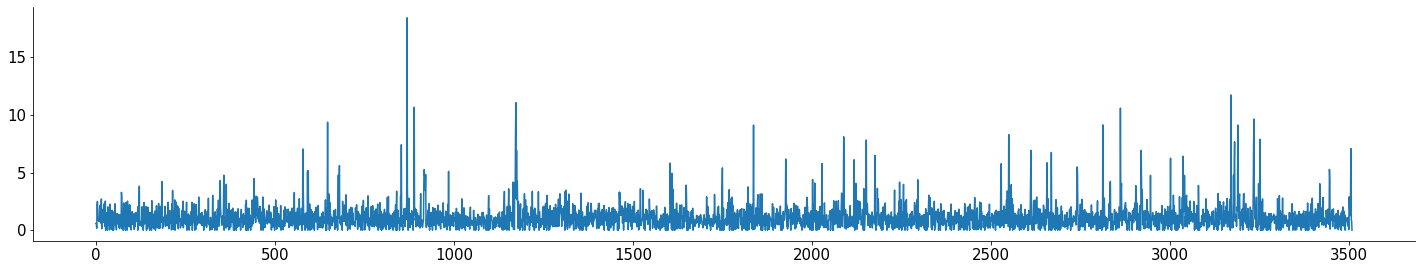

In [14]:
plt.plot(avgd_normed_dataRNN[0,:])

issue: does the individual scaling by layer introduce bias that may artificially increase performance of the network?

## Data Loader 


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
# set the seed
np.random.seed(42)

# number of neurons 
NN = dataRNN.shape[0]

In [18]:
# swapping the axes to maintain consistency with seq2seq notebook in the following code - the network takes all the neurons at a time step as input, not just one neuron

# avgd_normed_dataRNN = np.swapaxes(avgd_normed_dataRNN, 0, 1)
avgd_normed_dataRNN.shape

(10179, 3510)

In [19]:
frac = 4/5

#x1 = torch.from_numpy(dataRNN[:,:int(frac*dataRNN.shape[1])]).to(device).float().unsqueeze(0)
#x2 = torch.from_numpy(dataRNN[:,int(frac*dataRNN.shape[1]):]).to(device).float().unsqueeze(0)
#x1 = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)
#x2 = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)

n_neurs = 1131
# let's use n_neurs/10 latent components
ncomp = int(n_neurs/10)

x1_train = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,:int(frac*avgd_normed_dataRNN.shape[1])]).to(device).float().unsqueeze(2)
x2_train = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,:int(frac*avgd_normed_dataRNN.shape[1])]).to(device).float().unsqueeze(2)

x1_valid = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,int(frac*avgd_normed_dataRNN.shape[1]):]).to(device).float().unsqueeze(2)
x2_valid = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,int(frac*avgd_normed_dataRNN.shape[1]):]).to(device).float().unsqueeze(2)

NN1 = x1_train.shape[0]
NN2 = x2_train.shape[0]


In [20]:
class Net(nn.Module):
    def __init__(self, ncomp, NN1, NN2, num_layers = 1, dropout= 0,  bidi=True):
        super(Net, self).__init__()

        # play with some of the options in the RNN!
        
        self.rnn = nn.LSTM(NN1, ncomp, num_layers = num_layers, dropout = dropout,
                         bidirectional = bidi)
        """
        self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                    bidirectional = bidi, nonlinearity = 'tanh')
        self.rnn = nn.GRU(NN1, ncomp, num_layers = 1, dropout = 0,
                         bidirectional = bidi)
        """
        
        self.mlp = nn.Sequential(
                    nn.Linear(ncomp, ncomp*2),
                    nn.Mish(),
                    nn.Linear(ncomp*2, ncomp*2),
                    nn.Mish(),
                    nn.Dropout(0.25),
                    nn.Linear(ncomp*2, ncomp), 
                    nn.Mish())
        
        self.fc = nn.Linear(ncomp, NN2)

    def forward(self, x):
        x = x.permute(1, 2, 0)
        #print(x.shape)
        # h_0 = torch.zeros(2, x.size()[1], self.ncomp).to(device)
        
        y, h_n = self.rnn(x)

        #print(y.shape)
        #print(h_n.shape)
        if self.rnn.bidirectional:
          # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
          # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
            q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
        else:
            q = y
        
        q = self.mlp(q)

        # the softplus function is just like a relu but it's smoothed out so we can't predict 0
        # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
        #z = F.softplus(self.fc(q), 10)
        #print(q.shape)
        z = self.fc(q).permute(2, 0, 1)
        # print(z.shape)
        return z, q

In [22]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        'values': ['adam']
        },
    'num_layers': {
        'values': [1, 2, 3]
        },
    'dropout': {
          'values': [0.1, 0.2, 0.3, 0.5]
        },
    'weight_decay': {
          'values': [5e-5, 0., 1e-5]
        },
    }

sweep_config['parameters'] = parameters_dict

parameters_dict.update({
    'epochs': {
        'value': 5000}
    })

import math

parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'log_uniform',
        'min': -9.9,
        'max': -5.3
    },
})

import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'dropout': {'values': [0.1, 0.2, 0.3, 0.5]},
                'epochs': {'value': 5000},
                'learning_rate': {'distribution': 'log_uniform',
                                  'max': -5.3,
                                  'min': -9.9},
                'num_layers': {'values': [1, 2, 3]},
                'optimizer': {'values': ['adam']},
                'weight_decay': {'values': [5e-05, 0.0, 1e-05]}}}


In [25]:
sweep_id = wandb.sweep(sweep_config, project="NMAs-sweeps-test")

Create sweep with ID: ubgi39sv
Sweep URL: https://wandb.ai/sazio/NMAs-sweeps-test/sweeps/ubgi39sv


In [26]:
# you can keep re-running this cell if you think the cost might decrease further
cost = nn.MSELoss()

# rnn_loss = 0.2372, lstm_loss = 0.2340, gru_lstm = 0.2370

## Training 

In [ ]:
from tqdm import tqdm

In [28]:
def build_optimizer(network, optimizer, learning_rate, weight_decay): 
    optimizer = torch.optim.Adam(network.parameters(),
                               lr=learning_rate, weight_decay=weight_decay)
    return optimizer

def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        # loader = build_dataset(config.batch_size)
        # Net(ncomp, NN1, NN2, bidi = True).to(device)
        network = Net(ncomp, NN1, NN2, config.num_layers, config.dropout).to(device)
        optimizer = build_optimizer(network, config.optimizer, config.learning_rate, config.weight_decay)

        for epoch in range(config.epochs):
            # avg_loss = train_epoch(network, loader, optimizer)
            network.train()
            # the networkwork outputs the single-neuron prediction and the latents
            z, y = network(x1_train)

            # our cost
            loss = cost(z, x2_train)

            # train the networkwork as usual
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            with torch.no_grad():
                network.eval()
                valid_loss = cost(network(x1_valid)[0], x2_valid)

            if epoch % 50 == 0:
                with torch.no_grad():
                    network.eval()
                    valid_loss = cost(network(x1_valid)[0], x2_valid)
                    
                    print(f' iteration {epoch}, train cost {loss.item():.4f}, valid cost {valid_loss.item():.4f}')
            wandb.log({"train_loss": loss.item(), 'valid_loss': valid_loss.item(), "epoch": epoch})

In [ ]:
wandb.agent(sweep_id, train, count= 50)

wandb: Agent Starting Run: 3hpzkuuk with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 5000
wandb: 	learning_rate: 0.0027777260190408374
wandb: 	num_layers: 2
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6823, valid cost 3.7602
 iteration 50, train cost 2.0638, valid cost 2.1566
 iteration 100, train cost 2.0305, valid cost 2.1206
 iteration 150, train cost 1.9747, valid cost 2.0617
 iteration 200, train cost 1.9140, valid cost 2.0000
 iteration 250, train cost 1.8471, valid cost 1.9265
 iteration 300, train cost 1.7694, valid cost 1.8528
 iteration 350, train cost 1.7118, valid cost 1.8017
 iteration 400, train cost 1.6708, valid cost 1.7730
 iteration 450, train cost 1.6214, valid cost 1.7411
 iteration 500, train cost 1.5820, valid cost 1.7174
 iteration 550, train cost 1.5440, valid cost 1.6958
